In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from CoilSystem import CoilSystem
from InductanceSolver import InductanceSolver
from TransientResponse import TransientResponse

In [2]:
cs = CoilSystem(data_dir = 'coil_data')
cindex = cs.get_cindex()

ins = InductanceSolver(coil_system = cs, 
                       waveform_dir = 'waveform_data')

sol = ins.solve_system(ntimesteps = 1000)

tr = TransientResponse(coil_system = cs, 
                       inductance_solution = sol)

<Figure size 640x480 with 0 Axes>

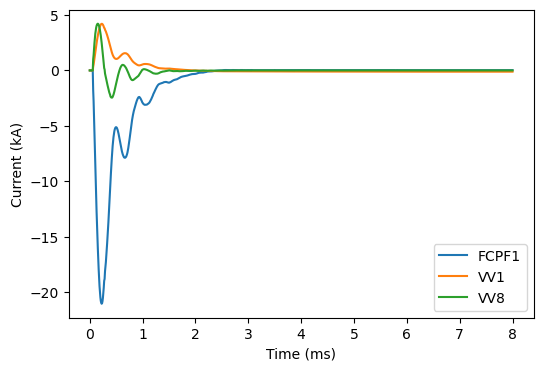

In [3]:
### Plot Coil Currents 

plt.figure()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for coil_name in ['FCPF1', 'VV1', 'VV8']:
    plt.plot(sol.t * 1e3, sol.y[cindex[coil_name]] * 1e-3, label = coil_name)

plt.xlabel('Time (ms)')
plt.ylabel('Current (kA)')
plt.legend()
plt.show()

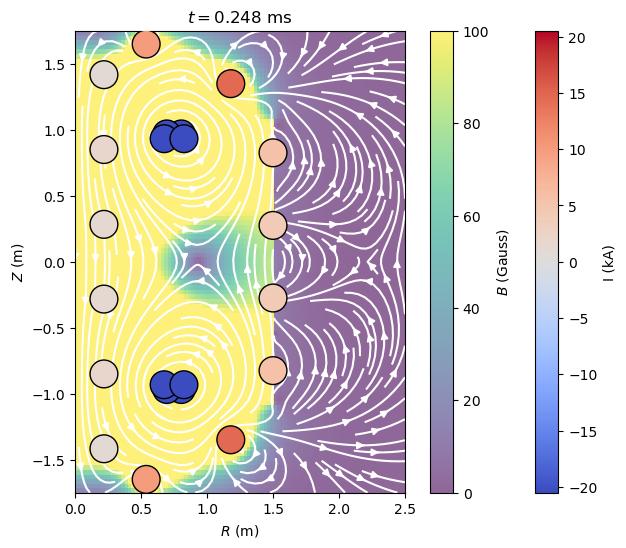

In [ ]:
### Calculate fields at a given time

tindex = tr.tindex(0.25e-3)

# Populate grid with magnetic fields

GRID_N = 100

R_vals = np.linspace(0, 2.5, GRID_N)
Z_vals = np.linspace(-1.75,  1.75, GRID_N)
Rs, Zs = np.meshgrid(R_vals, Z_vals)

Br_grid = np.zeros_like(Rs)
Bz_grid = np.zeros_like(Zs)

for i in range(Rs.shape[0]):
    for j in range(Rs.shape[1]):
        Br_grid[i, j], Bz_grid[i, j] = tr.calculate_field(tindex, Rs[i, j], Zs[i, j])

# Plot coils and fields

plt.figure(figsize=(8, 6))


coil_positions_r = cs.coil_coords[:, 0]
coil_positions_z = cs.coil_coords[:, 1]
coil_currents = sol.y[:, tindex]

vmax = np.max(np.abs(coil_currents / 1e3))
sc = plt.scatter(coil_positions_r, coil_positions_z, c=coil_currents / 1e3, s=400, cmap='coolwarm', edgecolors='black', zorder=3, vmin=-vmax, vmax=vmax)
plt.colorbar(sc, label='I (kA)')

B_mag = np.sqrt(Br_grid**2 + Bz_grid**2)
plt.imshow(B_mag * 1e4, extent=[R_vals.min(), R_vals.max(), Z_vals.min(), Z_vals.max()],
                origin='lower', aspect='auto', cmap='viridis', alpha=0.6, vmin=0, vmax=100)
plt.colorbar(label='$B$ (Gauss)')

plt.streamplot(Rs, Zs, Br_grid, Bz_grid, density=1.5, color = 'white')
plt.xlabel('$R$ (m)')
plt.ylabel('$Z$ (m)')
plt.xlim([0, max(R_vals)])
plt.ylim([Z_vals.min(), Z_vals.max()])
plt.gca().set_aspect('equal')
plt.title(f'$t =${sol.t[tindex] / 1e-3:.3f} ms')

plt.show()